In [3]:
import networkx as nx
import re


def parse(instance,row):
    split = row[0].split()
    
    number = split[0]
    instance.add_node(number)
    #G.add_edge(number,number)
    codes = row[1].split()
    if '.' in number:
        previouses = number.split('.')
        instance.add_edge(number,'.'.join(previouses[:-1]))
         
        
    #name = split[1]
    #ccs_codes = split[2:]
    
    instance.add_nodes_from(codes)
    edges = [(code,number) for code in codes]
    instance.add_edges_from(edges)
    #edges = [(code,code) for code in codes]
    #G.add_edges_from(edges)
    
    return number,codes

def create_graph(file,regex,mx):

    file = open(file,"r")
    content = file.read()
    file.close()
    groups = re.findall(regex,content,flags = 8)

    G = nx.DiGraph()

    nodes = [] #??
    
    for group in groups:
        number,codes = parse(G,group)
        nodes.append(codes)
        
    for root in range(1,mx+1): #depends..
        G.add_edge(f'{root}','0')
    return G,nodes

In [2]:

ccs_multi_diagnosis = 'CCS-MultiDiagnosisGrouper.txt'
ccs_multi_diagnosis_re = '^([\d\.?]+\s+[A-Za-z ]+.*[-\d]+)\s*?([\dA-Z\s]+)\n'

diagnosis, nodes = create_graph(ccs_multi_diagnosis,ccs_multi_diagnosis_re,18)

In [3]:

ccs_multi_procedures = 'CCS-MultiProceduresGrouper.txt'
ccs_multi_procedures_re = '^([\d\.?]+\s+).*?([\d+\s]+)\n'

procedures, nodes = create_graph(ccs_multi_procedures,ccs_multi_procedures_re,16)

In [4]:
#ccs_multi_procedures = 'CCS-MultiProceduresGrouper.txt'
#ccs_multi_procedures_re = '^([\d\.?]+\s+).*?([\d+\s]+)\n'

#procedures, nodes = create_graph(ccs_multi_procedures,ccs_multi_procedures_re,16)

In [4]:
from gensim.models.poincare import PoincareModel


In [6]:
def poincare(instance,file,epochs=40):
    embedding_sizes=[50,100,128,256,512]
    for embedding in embedding_sizes:
        print(f'Poincare for {embedding}')
        model = PoincareModel(list(instance.edges),negative=2,size=embedding)
        model.train(epochs=epochs)
        #print(model.evaluate())
        model.save(f"./embeddings/{file}-{embedding}")

In [ ]:
%%time
poincare(diagnosis,"diagnosis-poincare")


Poincare for 50
Poincare for 100
Poincare for 128


In [ ]:
%%time
poincare(procedures,"procedures-poincare")


In [ ]:
embedding_size=50
model = PoincareModel.load(f'./embeddings/diagnosis-poincare-{embedding_size}')


In [ ]:
list(diagnosis.nodes())[4:14]

In [ ]:
model.kv.distance('01002', '01006')


In [ ]:
from pyvis.network import Network

In [ ]:
net = Network(notebook=True)

In [ ]:
%%time
net.from_nx(diagnosis)

In [ ]:
net.show('example.html')

In [2]:
from Processing import get_or_create_diagnosis_ccs_graph


In [10]:
f_name = "CCS-MultiDiagnosisGrouper.txt"
G = nx.DiGraph()
G,idx,hierarchy = get_or_create_diagnosis_ccs_graph(G,f_name,connected=True,return_idx=True)
#d =nx.subgraph(G, list(idx.keys()))


This should never happen.. V173


In [5]:
model = PoincareModel.load(f'./embeddings/diagnosis-poincare-512')


In [16]:
import numpy as np

In [17]:
icd_embeddings = model.kv.get_normed_vectors()[list(idx.values())]
keys = np.array(list(idx.keys()))

In [18]:
from sklearn.manifold import TSNE

In [20]:
X_embedded = TSNE(n_components=2).fit_transform(icd_embeddings)

In [22]:
import random

In [24]:
def multi_level_group(code,hierarchy):
    group = hierarchy[code]
    group = group.split('.')
    #print(group)
    return group[0]
multi_level_grouped = [multi_level_group(str(item),hierarchy) for item in keys]
group = multi_level_grouped

In [26]:
import pandas as pd

CPU times: user 535 ms, sys: 48.4 ms, total: 583 ms
Wall time: 1 s


<AxesSubplot:xlabel='0', ylabel='1'>

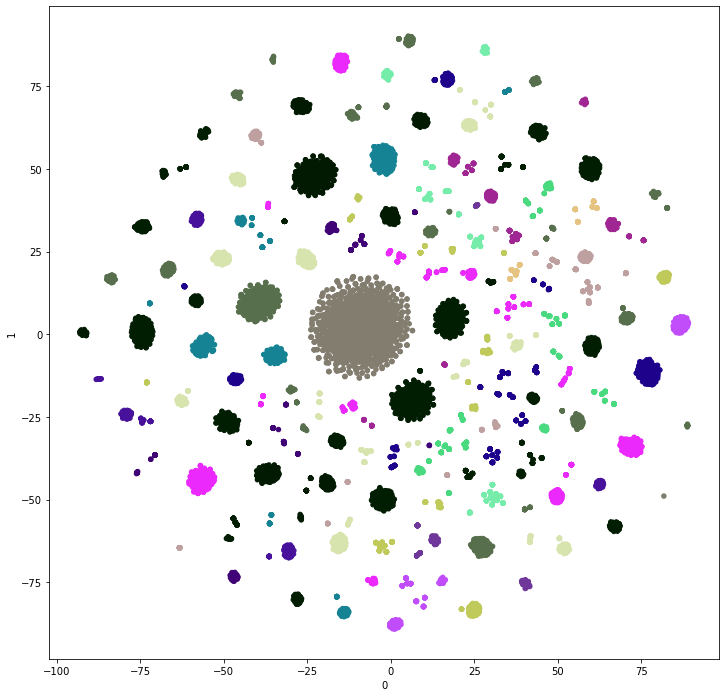

In [27]:
%%time
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(set(group)))]
color = pd.DataFrame(data={'color':color,'group':list(set(group))})
df = pd.DataFrame(group).set_index(0).merge(color,right_on='group',left_index=True)
pd.DataFrame(X_embedded).plot(kind='scatter',x=0,y=1,c = df.color,figsize=(12,12))